# Analysis of optimal scenarios agaisnt other scenarios

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
n_int_steps = 5


nnodes = 10  # nodes
ndays = 60

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
file_prefix = f''

Loaded Italy Setup with 10 nodes.


In [2]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(3)}

In [3]:
# Choose a subset of scenarios:
pick = '-U-R1-'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}

In [4]:
no_vacc = pd.read_csv(f'model_output/FR{pick}T1-int10-nc.csv', index_col= 'date', parse_dates=True)

In [5]:
# Generate alternatives:
# BY INCIDENCE: 
incid = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
incid.sort_values('value', ascending=False)
for scenario_name, scenario in scenarios.items():
    print(scenario_name)
    unvac_nd = np.copy(setup.pop_node)
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    control_initial = np.zeros((M, N))
    allocated_total = 0

    for nd in incid.sort_values('value', ascending=False).index:
        for k in range(N):
            if (allocated_total + max_vacc_rate[nd,k] < vacc_total) and (unvac_nd[nd] - max_vacc_rate[nd,k] > 0):
                control_initial[nd, k] = max_vacc_rate[nd,k]
                allocated_total += max_vacc_rate[nd,k]
                unvac_nd[nd] -= max_vacc_rate[nd,k]
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-inc{nnodes}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
# BY POPULATION 
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    control_initial = np.zeros((M, N))
    allocated_total = 0
    unvac_nd = np.copy(setup.pop_node)

    for nd in reversed(np.argsort(setup.pop_node)):
        for k in range(N):
            if (allocated_total + max_vacc_rate[nd, k] < vacc_total) and (unvac_nd[nd] - max_vacc_rate[nd,k] > 0):
                control_initial[nd, k] = max_vacc_rate[nd,k]
                allocated_total += max_vacc_rate[nd,k]
                unvac_nd[nd] -= max_vacc_rate[nd,k]
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-pop{nnodes}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

 58%|█████▊    | 34/59 [00:00<00:00, 337.45it/s]

FR-U-R1-T0.5
===> Integrating for model_output/FR-U-R1-T0.5-inc10


100%|██████████| 59/59 [00:00<00:00, 320.02it/s]

FR-U-R1-T1
===> Integrating for model_output/FR-U-R1-T1-inc10



100%|██████████| 59/59 [00:00<00:00, 330.34it/s]

FR-U-R1-T1.5
===> Integrating for model_output/FR-U-R1-T1.5-inc10



100%|██████████| 59/59 [00:00<00:00, 337.17it/s]

===> Integrating for model_output/FR-U-R1-T0.5-pop10



100%|██████████| 59/59 [00:00<00:00, 324.33it/s]

===> Integrating for model_output/FR-U-R1-T1-pop10



100%|██████████| 59/59 [00:00<00:00, 344.95it/s]

===> Integrating for model_output/FR-U-R1-T1.5-pop10


In [12]:
scn_results = pd.DataFrame(columns=['total_vacc', 'method', 'infected'])
methods = ['opt', 'int', 'inc', 'pop']
for met in methods:
    for scenario_name, scenario in scenarios.items():
        max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
        md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(vacc_total)],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses]
                                                                     })])
                                
baseline_infected = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
scn_results['averted'] = baseline_infected - scn_results['infected']
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

In [13]:
scn_results

,total_vacc,method,infected,doses,averted,avertedpervacc
0,500000,opt,4.407108e+07,4.916667e+05,1.385571e+06,2.818111
0,1000000,opt,4.391589e+07,9.833333e+05,1.540767e+06,1.566882
0,1500000,opt,4.389264e+07,1.475000e+06,1.564011e+06,1.060347
0,500000,int,4.408635e+07,5.000000e+05,1.370308e+06,2.740616
0,1000000,int,4.392360e+07,1.000000e+06,1.533055e+06,1.533055
0,1500000,int,4.389950e+07,1.499473e+06,1.557151e+06,1.038465
0,500000,inc,4.464327e+07,4.997307e+05,8.133819e+05,1.627640
0,1000000,inc,4.443277e+07,1.013046e+06,1.023889e+06,1.010703
0,1500000,inc,4.412899e+07,1.524571e+06,1.327665e+06,0.870845
0,500000,pop,4.466531e+07,4.999707e+05,7.913427e+05,1.582778


In [14]:
scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)

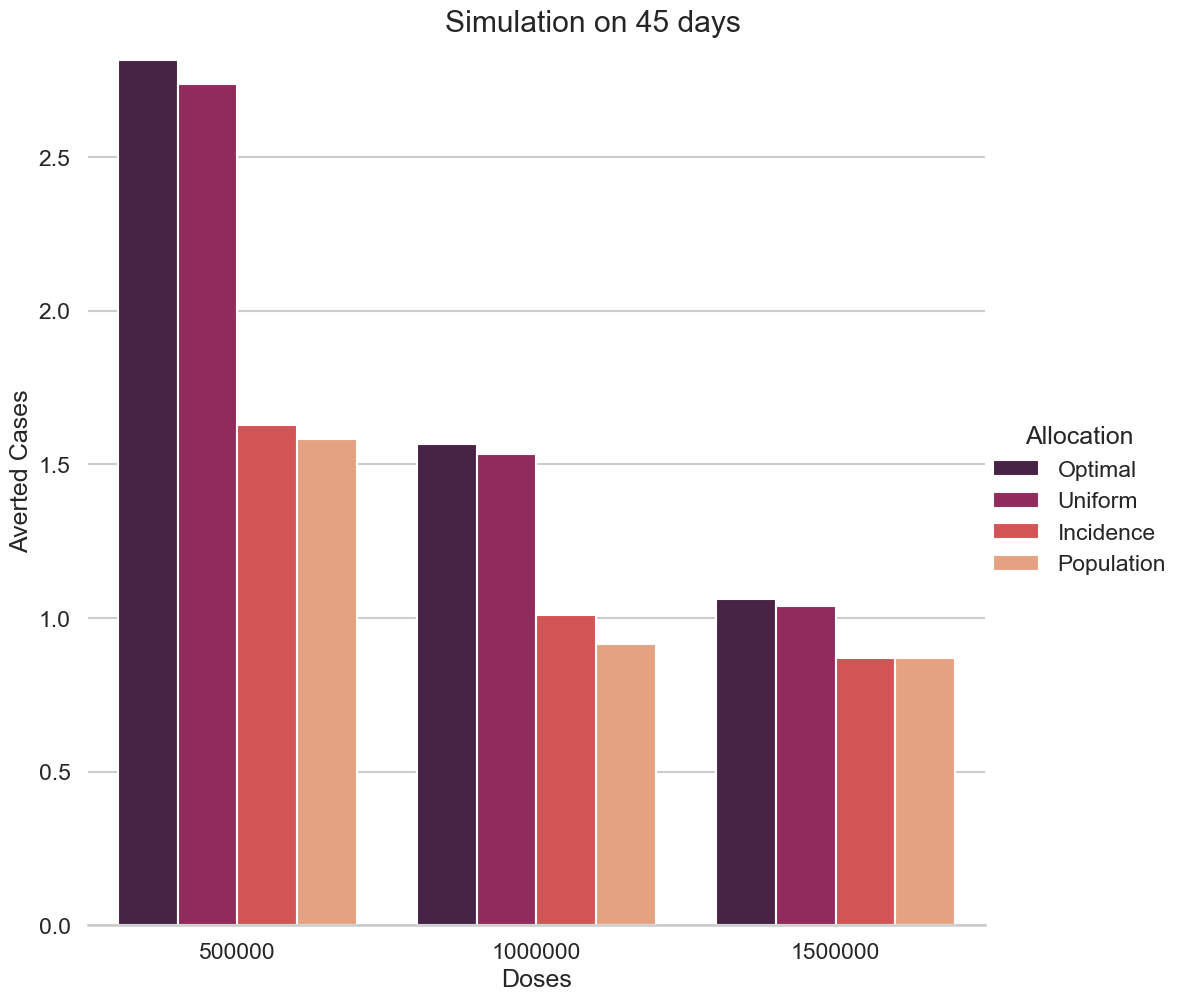

In [15]:
ndays = 45
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,10), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results, kind="bar",
    x="total_vacc", y="avertedpervacc", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.fig.suptitle(f'Simulation on {ndays} days')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
#g.set_xticklabels(['1M', '4M', '8M', '12M', '16M', '20M'])


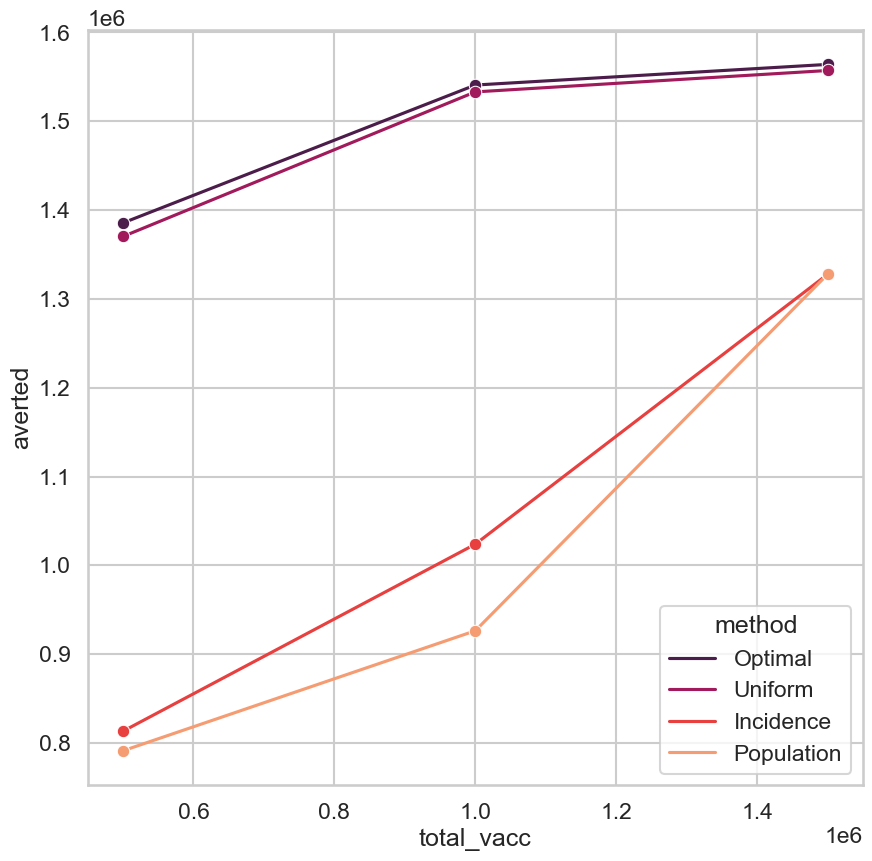

In [16]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (7).

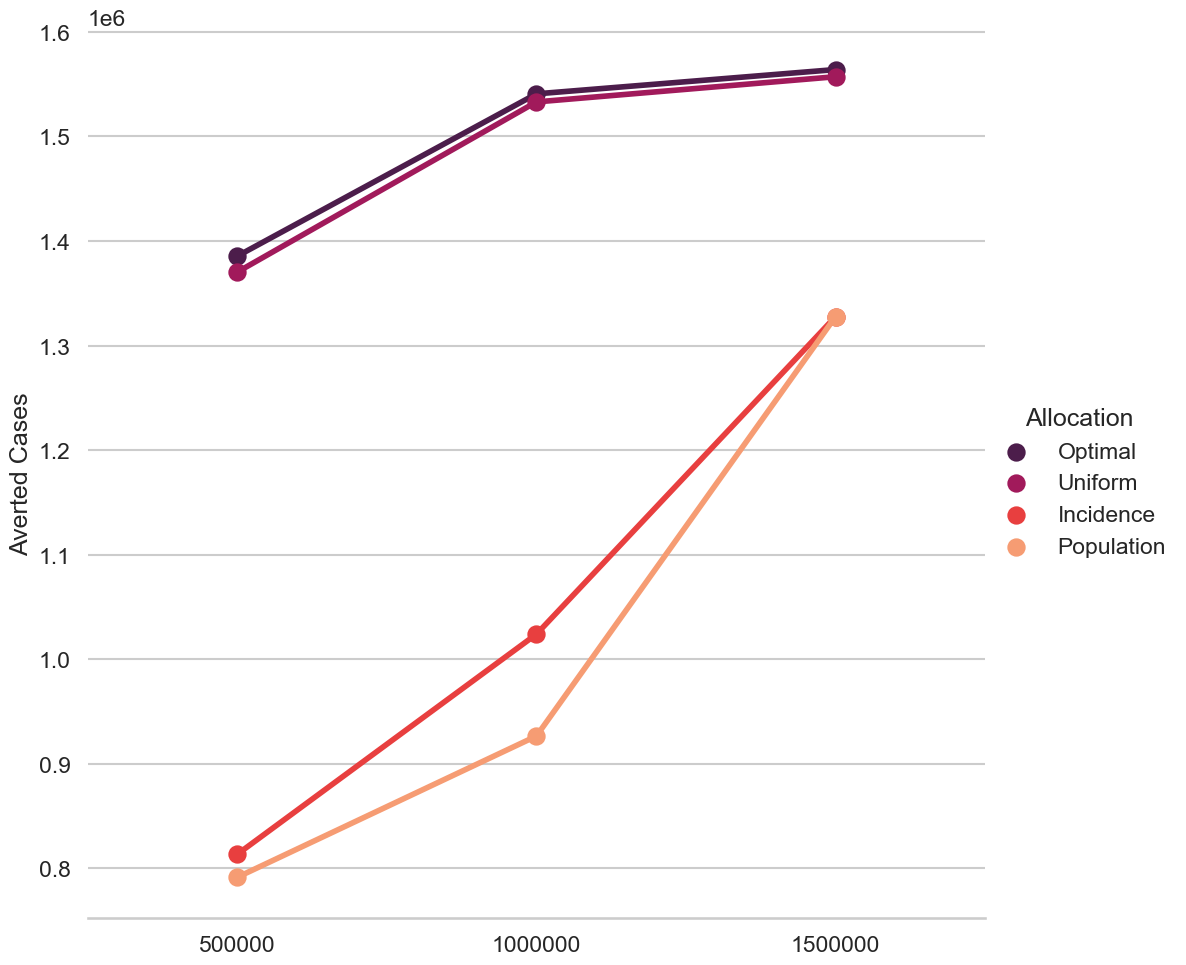

In [17]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels(['0', '1M', '4M', '8M', '12M', '16M', '20M'])